In [11]:
# =============================
# XGB + OPTUNA TIME SERIES PIPELINE
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import optuna
import warnings
import pickle
import os

In [5]:
warnings.filterwarnings("ignore")

In [6]:
dim_reduced_df = pd.read_csv('../data/feature-engineered/df_2_reduced_final.csv')

In [7]:
# -----------------------------
# CONFIG
# -----------------------------
financial_indicators = [
    '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', 
    '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 
    'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
]

recession_targets = [
    'recession_probability', '1_month_recession_probability',
    '3_month_recession_probability', '6_month_recession_probability'
]

In [14]:
# -----------------------------
# DATA SPLIT (same as your Prophet pipeline)
# -----------------------------
def prepare_data_split(df, date_col='date', split_year=2020):
    df[date_col] = pd.to_datetime(df[date_col])
    df_sorted = df.sort_values(date_col).reset_index(drop=True)
    train_data = df_sorted[df_sorted[date_col].dt.year < split_year].copy()
    test_data  = df_sorted[df_sorted[date_col].dt.year >= split_year].copy()
    print(f"Training: {len(train_data)} rows | Testing: {len(test_data)} rows")
    return train_data, test_data

# -----------------------------
# FEATURE ENGINEERING
# -----------------------------
def add_target_lags(df, target, lags=(1, 3, 6, 12)):
    """Create lag features for the given target ONLY (avoids leakage)."""
    df = df.copy()
    for l in lags:
        df[f"{target}_lag{l}"] = df[target].shift(l)
    return df

def clean_exog_cols(df, cols):
    """Replace inf and fill NaN values more aggressively."""
    cdf = df[['date'] + cols].copy()
    for c in cols:
        if c in cdf.columns:  # Safety check
            cdf[c] = cdf[c].replace([np.inf, -np.inf], np.nan)
            # More aggressive filling: forward fill, then backward fill, then median fill
            cdf[c] = cdf[c].fillna(method='ffill').fillna(method='bfill')
            # If still NaN (e.g., first few rows), fill with median
            if cdf[c].isna().any():
                cdf[c] = cdf[c].fillna(cdf[c].median())
            # If still NaN (all NaN column), fill with 0
            if cdf[c].isna().any():
                cdf[c] = cdf[c].fillna(0)
    return cdf

# -----------------------------
# TRAIN/VAL SPLIT FOR EARLY STOP
# -----------------------------
def time_val_split(train_df, val_ratio=0.2):
    """Keep order; last portion as validation."""
    n = len(train_df)
    cut = int(np.floor(n * (1 - val_ratio)))
    return train_df.iloc[:cut].copy(), train_df.iloc[cut:].copy()

# -----------------------------
# OPTUNA OBJECTIVE
# -----------------------------
def make_objective(X_train, y_train, X_val, y_val, random_state=42):
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 2000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 2, 8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 5.0),
            "random_state": random_state,
            "objective": "reg:squarederror",
            "tree_method": "hist",
            "early_stopping_rounds": 100,  # Move to params
        }
        model = XGBRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        # Use the best iteration chosen by early stopping implicitly
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        return rmse
    return objective

# -----------------------------
# TRAIN + PREDICT + EVAL
# -----------------------------
def train_predict_xgb_optuna(train_df, test_df, target, exog_cols, lags=(1,3,6,12), n_trials=50, seed=42, verbose=True):
    """
    Build lag features for target, tune with Optuna on a time-aware val split,
    retrain on full training, predict on test, return preds and metrics.
    """
    if target not in train_df.columns:
        if verbose:
            print(f"❌ Target {target} not found in training data")
        return None, None, None, None, None

    # Debug: Check data before processing
    if verbose:
        print(f"🔍 DEBUG: Initial train shape: {train_df.shape}, test shape: {test_df.shape}")
        print(f"🔍 DEBUG: Target {target} - train nulls: {train_df[target].isna().sum()}, test nulls: {test_df[target].isna().sum()}")

    # 1) Build lag features (on concatenated df to align indices cleanly)
    df_all = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    df_all = add_target_lags(df_all, target, lags=lags)

    if verbose:
        print(f"🔍 DEBUG: After adding lags, shape: {df_all.shape}")
        lag_cols = [f"{target}_lag{l}" for l in lags]
        print(f"🔍 DEBUG: Lag column nulls: {df_all[lag_cols].isna().sum().to_dict()}")

    # 2) Prepare feature columns 
    feature_cols = exog_cols + [f"{target}_lag{l}" for l in lags]
    # Filter to only include columns that actually exist
    feature_cols = [c for c in feature_cols if c in df_all.columns]
    
    if verbose:
        print(f"🔍 DEBUG: Using {len(feature_cols)} features: {feature_cols[:5]}..." if len(feature_cols) > 5 else f"🔍 DEBUG: Using {len(feature_cols)} features: {feature_cols}")

    use_cols = ['date', target] + feature_cols
    df_all = df_all[use_cols].copy()

    # Clean exogenous columns
    if feature_cols:  # Only clean if we have features
        if verbose:
            print(f"🔍 DEBUG: Before cleaning - NaN counts in features:")
            for col in feature_cols[:10]:  # Show first 10 feature columns
                if col in df_all.columns:
                    nan_count = df_all[col].isna().sum()
                    print(f"   {col}: {nan_count} NaNs")
        
        exog_clean = clean_exog_cols(df_all, feature_cols)
        df_all = df_all[['date', target]].merge(exog_clean, on='date', how='inner')
        
        if verbose:
            print(f"🔍 DEBUG: After cleaning - NaN counts in features:")
            for col in feature_cols[:10]:  # Show first 10 feature columns
                if col in df_all.columns:
                    nan_count = df_all[col].isna().sum()
                    print(f"   {col}: {nan_count} NaNs")

    if verbose:
        print(f"🔍 DEBUG: After cleaning, shape: {df_all.shape}")
        print(f"🔍 DEBUG: Total nulls in df_all: {df_all.isna().sum().sum()}")

    # Drop rows with NaNs (but be more strategic about it)
    initial_rows = len(df_all)
    # Check how many columns have NaNs before dropping
    nan_counts_by_col = df_all.isna().sum()
    if verbose:
        problem_cols = nan_counts_by_col[nan_counts_by_col > 0]
        if len(problem_cols) > 0:
            print(f"🔍 DEBUG: Columns with NaNs before dropping: {problem_cols.to_dict()}")
    
    df_all = df_all.dropna().reset_index(drop=True)
    final_rows = len(df_all)
    
    if verbose:
        print(f"🔍 DEBUG: Dropped {initial_rows - final_rows} rows with NaN (kept {final_rows})")

    if final_rows == 0:
        if verbose:
            print(f"❌ No rows left after dropping NaNs for {target}")
        return None, None, None, None, None

    # 4) Re-split by date into train/test after lagging/cleaning
    train_mask = df_all['date'] < pd.Timestamp('2020-01-01')
    test_mask = df_all['date'] >= pd.Timestamp('2020-01-01')

    df_tr = df_all.loc[train_mask].copy()
    df_te = df_all.loc[test_mask].copy()

    if verbose:
        print(f"🔍 DEBUG: After date split - train: {len(df_tr)}, test: {len(df_te)}")

    if len(df_tr) < 20:  # Too small to proceed
        if verbose:
            print(f"⚠️  Very small training set after lagging for {target}: {len(df_tr)} rows")
        return None, None, None, None, None
            
    if len(df_te) == 0:
        if verbose:
            print(f"⚠️  No test rows after 2020 for {target}")
        return None, None, None, None, None

    X_tr_full = df_tr[feature_cols].values
    y_tr_full = df_tr[target].values
    X_te = df_te[feature_cols].values
    y_te = df_te[target].values

    # 5) Time-aware validation split inside training for early stopping
    tr_sub, val_sub = time_val_split(df_tr)
    X_tr = tr_sub[feature_cols].values
    y_tr = tr_sub[target].values
    X_val = val_sub[feature_cols].values
    y_val = val_sub[target].values

    # 6) Optuna tuning
    study = optuna.create_study(direction="minimize")
    study.optimize(make_objective(X_tr, y_tr, X_val, y_val, random_state=seed), n_trials=n_trials, show_progress_bar=False)
    best_params = study.best_params
    if verbose:
        print(f"🔧 Best params for {target}: {best_params}")
        print(f"   Best val RMSE: {study.best_value:.4f}")

    # 7) Retrain on FULL training (train+val) with best params and early stopping using last 20% as val
    # (recreate split to feed eval_set)
    tr_df_sub, val_df_sub = time_val_split(df_tr)
    X_tr2, y_tr2 = tr_df_sub[feature_cols].values, tr_df_sub[target].values
    X_val2, y_val2 = val_df_sub[feature_cols].values, val_df_sub[target].values

    model = XGBRegressor(
        **{k: v for k, v in best_params.items() if k not in ["random_state", "early_stopping_rounds"]},
        random_state=seed,
        objective="reg:squarederror",
        tree_method="hist",
        early_stopping_rounds=100
    )
    model.fit(
        X_tr2, y_tr2,
        eval_set=[(X_val2, y_val2)],
        verbose=False
    )

    # 8) Predict on TEST
    y_pred = model.predict(X_te)

    # 9) Metrics
    mae = mean_absolute_error(y_te, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    def safe_mape(y_true, y_hat, eps=1e-8):
        return float(np.mean(np.abs((y_true - y_hat) / np.maximum(np.abs(y_true), eps))) * 100.0)
    mape = safe_mape(y_te, y_pred)

    # 10) Plot Actual vs Forecast on test range
    plt.figure(figsize=(10,5))
    plt.plot(df_te['date'], y_te, label='Actual', linewidth=2)
    plt.plot(df_te['date'], y_pred, label='Forecast', linewidth=2)
    plt.title(f"XGB Forecast vs Actual — {target}")
    plt.xlabel("Date"); plt.ylabel(target)
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout()
    plt.show()

    return model, df_te[['date']].assign(actual=y_te, forecast=y_pred), mae, rmse, mape

# -----------------------------
# RUN PIPELINE
# -----------------------------
def run_xgb_optuna_pipeline(
    df,
    financial_indicators,
    recession_targets,
    lags=(1,3,6,12),
    n_trials=40,
    include_exog=True,
    plot_results=True,
    seed=42
):
    """
    - Splits by date (<2020 train, >=2020 test)
    - For each target in financial_indicators:
        * builds lag features for that target,
        * uses all non-target, non-recession, non-date columns as exogenous (if include_exog=True),
        * tunes XGB with Optuna,
        * predicts on 2020+,
        * collects metrics.
    """
    # Base split (for reporting only)
    train_data, test_data = prepare_data_split(df)

    # Define exogenous columns ONCE (exclude date, all financial indicators, and recession targets)
    exog_cols = []
    if include_exog:
        exog_cols = [
            c for c in df.columns
            if c not in (['date'] + financial_indicators + recession_targets)
        ]
        print(f"🔧 Using {len(exog_cols)} exogenous features (excludes recession targets & targets)")

    metrics_rows = []
    forecasts = {}

    for target in financial_indicators:
        print("\n" + "="*60)
        print(f"XGBoost + Optuna Forecasting: {target}")
        print("="*60)

        model, test_pred_df, mae, rmse, mape = train_predict_xgb_optuna(
            train_data, test_data, target,
            exog_cols=exog_cols,
            lags=lags,
            n_trials=n_trials,
            seed=seed,
            verbose=True
        )

        if model is None:
            print(f"❌ Skipping {target} due to data issues.")
            continue

        os.makedirs("models", exist_ok=True)
        model_filename = f"models/xgb_model_{target}.pkl"
        with open(model_filename, "wb") as f:
            pickle.dump(model, f)
        print(f"✅ Model for {target} saved to {model_filename}")

        forecasts[target] = test_pred_df
        metrics_rows.append({
            "Indicator": target,
            "MAE": round(mae, 4),
            "RMSE": round(rmse, 4),
            "MAPE_%": round(mape, 4)
        })

    # Handle case where no models succeeded
    if not metrics_rows:
        print("\n❌ No models succeeded. Check your data quality and feature engineering.")
        return {
            "metrics": pd.DataFrame(columns=["MAE", "RMSE", "MAPE_%"]),
            "forecasts": {}
        }

    metrics_df = pd.DataFrame(metrics_rows).set_index("Indicator").sort_index()
    print("\n📊 Forecast Performance Metrics (TEST: 2020+)")
    print(metrics_df)

    



    return {
        "metrics": metrics_df,
        "forecasts": forecasts
    }

[I 2025-09-06 23:56:21,196] A new study created in memory with name: no-name-e549059b-649c-4e08-8360-0b955d6d1074


Training: 635 rows | Testing: 65 rows
🔧 Using 33 exogenous features (excludes recession targets & targets)

XGBoost + Optuna Forecasting: 1_year_rate
🔍 DEBUG: Initial train shape: (635, 50), test shape: (65, 50)
🔍 DEBUG: Target 1_year_rate - train nulls: 79, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 54)
🔍 DEBUG: Lag column nulls: {'1_year_rate_lag1': 80, '1_year_rate_lag3': 82, '1_year_rate_lag6': 85, '1_year_rate_lag12': 91}
🔍 DEBUG: Using 37 features: ['seasonally_adjusted_unemployment_rate', 'CPI_trend', 'CPI_sumsq_acf_diff1', 'seasonally_adjusted_CPI', 'INDPRO_trend']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_unemployment_rate: 0 NaNs
   CPI_trend: 0 NaNs
   CPI_sumsq_acf_diff1: 11 NaNs
   seasonally_adjusted_CPI: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   INDPRO_acf1_original: 10 NaNs
   CPI_sumsq_acf_original: 10 NaNs
   INDPRO_sumsq_acf_original: 10 NaNs
   CPI_acf1_original: 10 NaNs
🔍 DEBUG: After clea

[I 2025-09-06 23:56:21,728] Trial 0 finished with value: 0.7507286556465044 and parameters: {'n_estimators': 942, 'learning_rate': 0.08864859282387078, 'max_depth': 7, 'min_child_weight': 2.5981876075142, 'subsample': 0.6344371311804481, 'colsample_bytree': 0.6335138068876054, 'gamma': 0.47863683384721356, 'reg_alpha': 3.037554630994126, 'reg_lambda': 3.464102788643201}. Best is trial 0 with value: 0.7507286556465044.
[I 2025-09-06 23:56:22,288] Trial 1 finished with value: 0.8302339669876347 and parameters: {'n_estimators': 538, 'learning_rate': 0.04886345618076004, 'max_depth': 7, 'min_child_weight': 7.926492066055658, 'subsample': 0.7791600391206294, 'colsample_bytree': 0.616765427197553, 'gamma': 2.87262469577084, 'reg_alpha': 3.906521355953458, 'reg_lambda': 2.930872253660479}. Best is trial 0 with value: 0.7507286556465044.
[I 2025-09-06 23:56:23,729] Trial 2 finished with value: 0.6829152019683425 and parameters: {'n_estimators': 1630, 'learning_rate': 0.011750570711997775, 'max

🔧 Best params for 1_year_rate: {'n_estimators': 1702, 'learning_rate': 0.01618730713327899, 'max_depth': 6, 'min_child_weight': 1.1199658822084424, 'subsample': 0.948173165240491, 'colsample_bytree': 0.7217507810800797, 'gamma': 2.283635240686821, 'reg_alpha': 0.059787007257210575, 'reg_lambda': 1.087385987263949}
   Best val RMSE: 0.6543


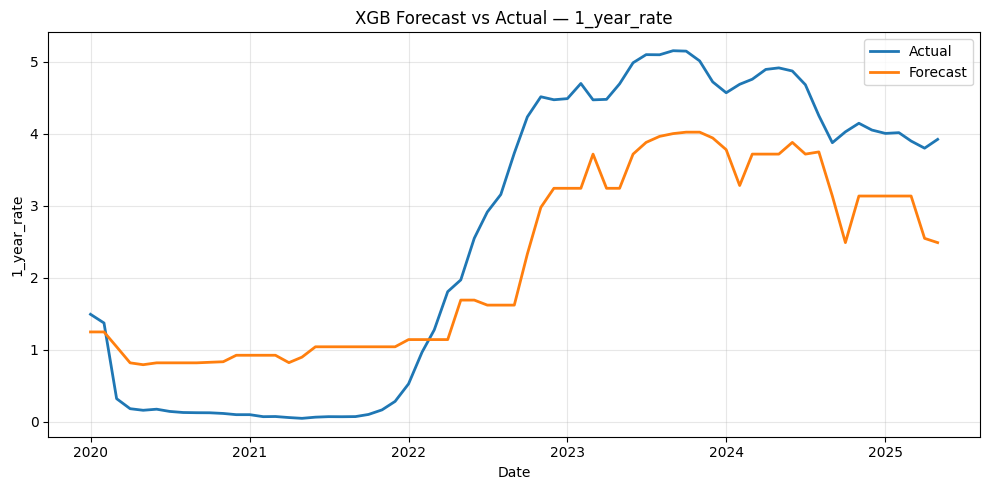

[I 2025-09-06 23:57:01,537] A new study created in memory with name: no-name-bbbcca87-b5ef-4fc1-827f-fe4fb9f06fc3


✅ Model for 1_year_rate saved to models/xgb_model_1_year_rate.pkl

XGBoost + Optuna Forecasting: 3_months_rate
🔍 DEBUG: Initial train shape: (635, 50), test shape: (65, 50)
🔍 DEBUG: Target 3_months_rate - train nulls: 0, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 54)
🔍 DEBUG: Lag column nulls: {'3_months_rate_lag1': 1, '3_months_rate_lag3': 3, '3_months_rate_lag6': 6, '3_months_rate_lag12': 12}
🔍 DEBUG: Using 37 features: ['seasonally_adjusted_unemployment_rate', 'CPI_trend', 'CPI_sumsq_acf_diff1', 'seasonally_adjusted_CPI', 'INDPRO_trend']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_unemployment_rate: 0 NaNs
   CPI_trend: 0 NaNs
   CPI_sumsq_acf_diff1: 11 NaNs
   seasonally_adjusted_CPI: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   INDPRO_acf1_original: 10 NaNs
   CPI_sumsq_acf_original: 10 NaNs
   INDPRO_sumsq_acf_original: 10 NaNs
   CPI_acf1_original: 10 NaNs
🔍 DEBUG: After cleaning - NaN counts in features:
  

[I 2025-09-06 23:57:02,590] Trial 0 finished with value: 0.9146912389879593 and parameters: {'n_estimators': 768, 'learning_rate': 0.01791979442928801, 'max_depth': 6, 'min_child_weight': 4.125293638467716, 'subsample': 0.825325952352965, 'colsample_bytree': 0.870172672013305, 'gamma': 3.940820182244422, 'reg_alpha': 2.7450757087848765, 'reg_lambda': 0.8092208046364908}. Best is trial 0 with value: 0.9146912389879593.
[I 2025-09-06 23:57:04,106] Trial 1 finished with value: 0.9864814810240942 and parameters: {'n_estimators': 1778, 'learning_rate': 0.01678109111053037, 'max_depth': 4, 'min_child_weight': 7.886661751109524, 'subsample': 0.6568013870209207, 'colsample_bytree': 0.6768899597544149, 'gamma': 3.177195204251289, 'reg_alpha': 1.7628011165044692, 'reg_lambda': 3.7099794801425467}. Best is trial 0 with value: 0.9146912389879593.
[I 2025-09-06 23:57:04,553] Trial 2 finished with value: 0.8124451390323356 and parameters: {'n_estimators': 1905, 'learning_rate': 0.07698659127557551, 

🔧 Best params for 3_months_rate: {'n_estimators': 218, 'learning_rate': 0.2187736345150664, 'max_depth': 7, 'min_child_weight': 9.488796200285972, 'subsample': 0.6691179003791184, 'colsample_bytree': 0.7394278421449444, 'gamma': 0.25420157150044165, 'reg_alpha': 0.33737385645443385, 'reg_lambda': 1.203052319099843}
   Best val RMSE: 0.2788


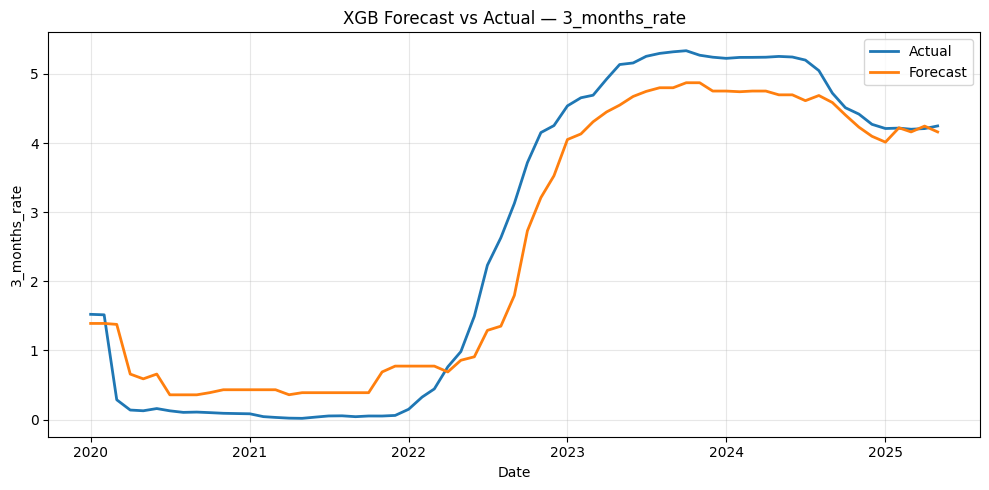

[I 2025-09-06 23:57:26,971] A new study created in memory with name: no-name-3c84d7db-04b7-41cf-bff3-d6ff6786fe79


✅ Model for 3_months_rate saved to models/xgb_model_3_months_rate.pkl

XGBoost + Optuna Forecasting: 6_months_rate
🔍 DEBUG: Initial train shape: (635, 50), test shape: (65, 50)
🔍 DEBUG: Target 6_months_rate - train nulls: 0, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 54)
🔍 DEBUG: Lag column nulls: {'6_months_rate_lag1': 1, '6_months_rate_lag3': 3, '6_months_rate_lag6': 6, '6_months_rate_lag12': 12}
🔍 DEBUG: Using 37 features: ['seasonally_adjusted_unemployment_rate', 'CPI_trend', 'CPI_sumsq_acf_diff1', 'seasonally_adjusted_CPI', 'INDPRO_trend']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_unemployment_rate: 0 NaNs
   CPI_trend: 0 NaNs
   CPI_sumsq_acf_diff1: 11 NaNs
   seasonally_adjusted_CPI: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   INDPRO_acf1_original: 10 NaNs
   CPI_sumsq_acf_original: 10 NaNs
   INDPRO_sumsq_acf_original: 10 NaNs
   CPI_acf1_original: 10 NaNs
🔍 DEBUG: After cleaning - NaN counts in features

[I 2025-09-06 23:57:27,506] Trial 0 finished with value: 0.8662604947454392 and parameters: {'n_estimators': 1384, 'learning_rate': 0.05254339676683796, 'max_depth': 2, 'min_child_weight': 1.1794285581008703, 'subsample': 0.9600715463567608, 'colsample_bytree': 0.6129413399000561, 'gamma': 4.0197144450055875, 'reg_alpha': 0.0025995756601193687, 'reg_lambda': 4.619974558349857}. Best is trial 0 with value: 0.8662604947454392.
[I 2025-09-06 23:57:28,065] Trial 1 finished with value: 0.8205775154835675 and parameters: {'n_estimators': 323, 'learning_rate': 0.034585748053647745, 'max_depth': 7, 'min_child_weight': 7.709152851195467, 'subsample': 0.9394042087949248, 'colsample_bytree': 0.9113094108642608, 'gamma': 2.273307154327975, 'reg_alpha': 1.176365556070646, 'reg_lambda': 2.756103073383104}. Best is trial 1 with value: 0.8205775154835675.
[I 2025-09-06 23:57:28,383] Trial 2 finished with value: 0.9074796839786619 and parameters: {'n_estimators': 706, 'learning_rate': 0.102396123922410

🔧 Best params for 6_months_rate: {'n_estimators': 1994, 'learning_rate': 0.14648010359536234, 'max_depth': 2, 'min_child_weight': 1.5315133342041207, 'subsample': 0.8190195252614897, 'colsample_bytree': 0.8701033344396418, 'gamma': 0.33138846295715335, 'reg_alpha': 0.17992067577193316, 'reg_lambda': 4.527410717056412}
   Best val RMSE: 0.4479


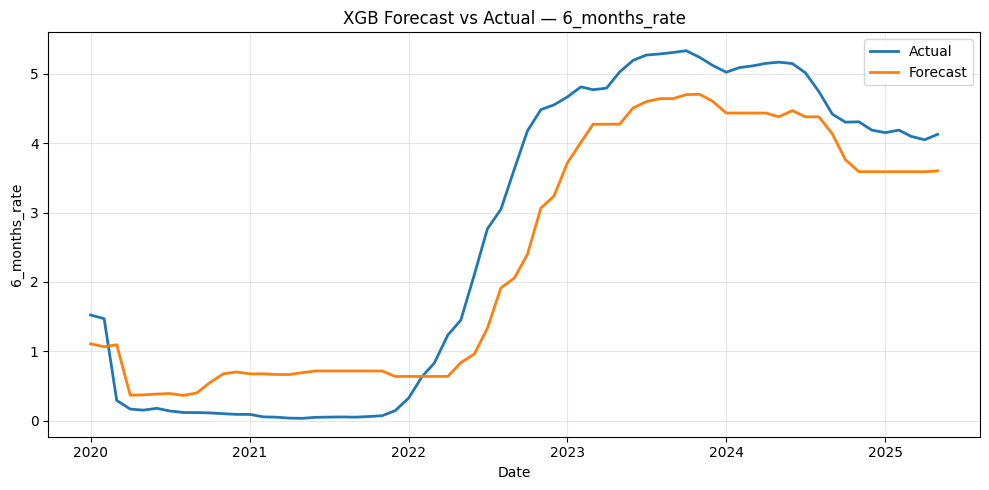

[I 2025-09-06 23:57:52,544] A new study created in memory with name: no-name-266df7a6-e290-44e1-b9fc-b7d6e5546a55


✅ Model for 6_months_rate saved to models/xgb_model_6_months_rate.pkl

XGBoost + Optuna Forecasting: CPI
🔍 DEBUG: Initial train shape: (635, 50), test shape: (65, 50)
🔍 DEBUG: Target CPI - train nulls: 0, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 54)
🔍 DEBUG: Lag column nulls: {'CPI_lag1': 1, 'CPI_lag3': 3, 'CPI_lag6': 6, 'CPI_lag12': 12}
🔍 DEBUG: Using 37 features: ['seasonally_adjusted_unemployment_rate', 'CPI_trend', 'CPI_sumsq_acf_diff1', 'seasonally_adjusted_CPI', 'INDPRO_trend']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_unemployment_rate: 0 NaNs
   CPI_trend: 0 NaNs
   CPI_sumsq_acf_diff1: 11 NaNs
   seasonally_adjusted_CPI: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   INDPRO_acf1_original: 10 NaNs
   CPI_sumsq_acf_original: 10 NaNs
   INDPRO_sumsq_acf_original: 10 NaNs
   CPI_acf1_original: 10 NaNs
🔍 DEBUG: After cleaning - NaN counts in features:
   seasonally_adjusted_unemployment_rate: 0 NaNs
   CPI_tr

[I 2025-09-06 23:57:53,232] Trial 0 finished with value: 22.93198892113842 and parameters: {'n_estimators': 1099, 'learning_rate': 0.04643198640608668, 'max_depth': 2, 'min_child_weight': 6.075403531005036, 'subsample': 0.8705153140645903, 'colsample_bytree': 0.6012914639994587, 'gamma': 0.6739714200532526, 'reg_alpha': 3.03518655328681, 'reg_lambda': 1.3216705215022422}. Best is trial 0 with value: 22.93198892113842.
[I 2025-09-06 23:57:54,839] Trial 1 finished with value: 22.52066134275457 and parameters: {'n_estimators': 1397, 'learning_rate': 0.021079567811577243, 'max_depth': 8, 'min_child_weight': 3.440461082644562, 'subsample': 0.9975453260964684, 'colsample_bytree': 0.8611610803110845, 'gamma': 4.763127758975331, 'reg_alpha': 0.4272329274033926, 'reg_lambda': 1.519662187838044}. Best is trial 1 with value: 22.52066134275457.
[I 2025-09-06 23:57:55,218] Trial 2 finished with value: 23.696859276718037 and parameters: {'n_estimators': 373, 'learning_rate': 0.1218425836589943, 'max

🔧 Best params for CPI: {'n_estimators': 1789, 'learning_rate': 0.02329444859748405, 'max_depth': 8, 'min_child_weight': 2.936571959478346, 'subsample': 0.9074579917112169, 'colsample_bytree': 0.9776508366423388, 'gamma': 0.5093676725881169, 'reg_alpha': 0.006603415195293838, 'reg_lambda': 0.9467452409722754}
   Best val RMSE: 21.6082


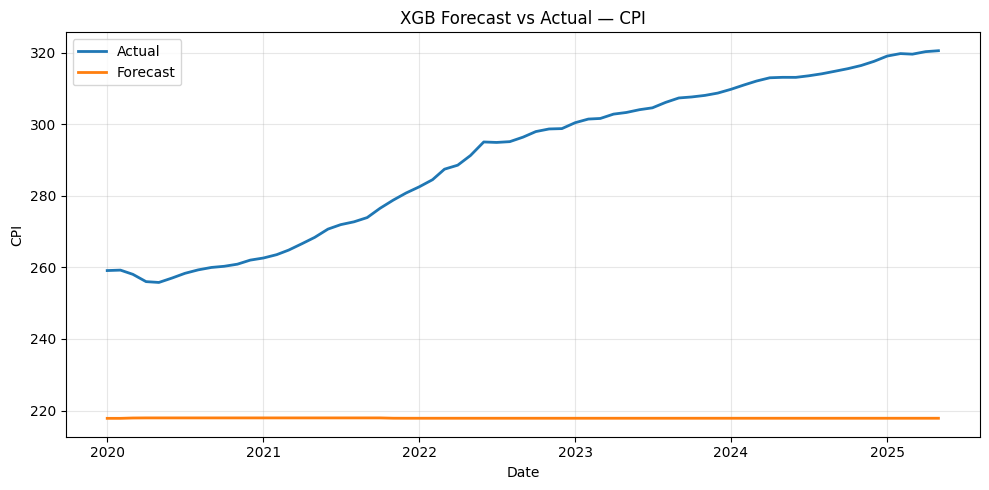

[I 2025-09-06 23:58:40,151] A new study created in memory with name: no-name-644528a7-579d-4312-9fce-cefedd6e4f3a


✅ Model for CPI saved to models/xgb_model_CPI.pkl

XGBoost + Optuna Forecasting: INDPRO
🔍 DEBUG: Initial train shape: (635, 50), test shape: (65, 50)
🔍 DEBUG: Target INDPRO - train nulls: 0, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 54)
🔍 DEBUG: Lag column nulls: {'INDPRO_lag1': 1, 'INDPRO_lag3': 3, 'INDPRO_lag6': 6, 'INDPRO_lag12': 12}
🔍 DEBUG: Using 37 features: ['seasonally_adjusted_unemployment_rate', 'CPI_trend', 'CPI_sumsq_acf_diff1', 'seasonally_adjusted_CPI', 'INDPRO_trend']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_unemployment_rate: 0 NaNs
   CPI_trend: 0 NaNs
   CPI_sumsq_acf_diff1: 11 NaNs
   seasonally_adjusted_CPI: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   INDPRO_acf1_original: 10 NaNs
   CPI_sumsq_acf_original: 10 NaNs
   INDPRO_sumsq_acf_original: 10 NaNs
   CPI_acf1_original: 10 NaNs
🔍 DEBUG: After cleaning - NaN counts in features:
   seasonally_adjusted_unemployment_rate: 0 NaNs
   CPI_tren

[I 2025-09-06 23:58:40,619] Trial 0 finished with value: 1.43739926545896 and parameters: {'n_estimators': 1586, 'learning_rate': 0.05050348532652518, 'max_depth': 6, 'min_child_weight': 1.4996712859553623, 'subsample': 0.6087084091954803, 'colsample_bytree': 0.6175752604870612, 'gamma': 3.2974817631980584, 'reg_alpha': 1.221595778346967, 'reg_lambda': 3.6916617499776354}. Best is trial 0 with value: 1.43739926545896.
[I 2025-09-06 23:58:40,897] Trial 1 finished with value: 1.1458425227086313 and parameters: {'n_estimators': 827, 'learning_rate': 0.257476354570283, 'max_depth': 5, 'min_child_weight': 4.263900200303979, 'subsample': 0.9240822861699292, 'colsample_bytree': 0.8504613278577049, 'gamma': 3.6340697914928723, 'reg_alpha': 2.4753180150714806, 'reg_lambda': 2.2558397976992324}. Best is trial 1 with value: 1.1458425227086313.
[I 2025-09-06 23:58:41,207] Trial 2 finished with value: 0.9206797419018552 and parameters: {'n_estimators': 1251, 'learning_rate': 0.1615672778980464, 'ma

🔧 Best params for INDPRO: {'n_estimators': 1931, 'learning_rate': 0.15953718526752567, 'max_depth': 6, 'min_child_weight': 6.967387382593787, 'subsample': 0.8561484996984344, 'colsample_bytree': 0.7294598332826354, 'gamma': 0.46007781536874326, 'reg_alpha': 0.04501339900697569, 'reg_lambda': 0.6486951935231278}
   Best val RMSE: 0.7716


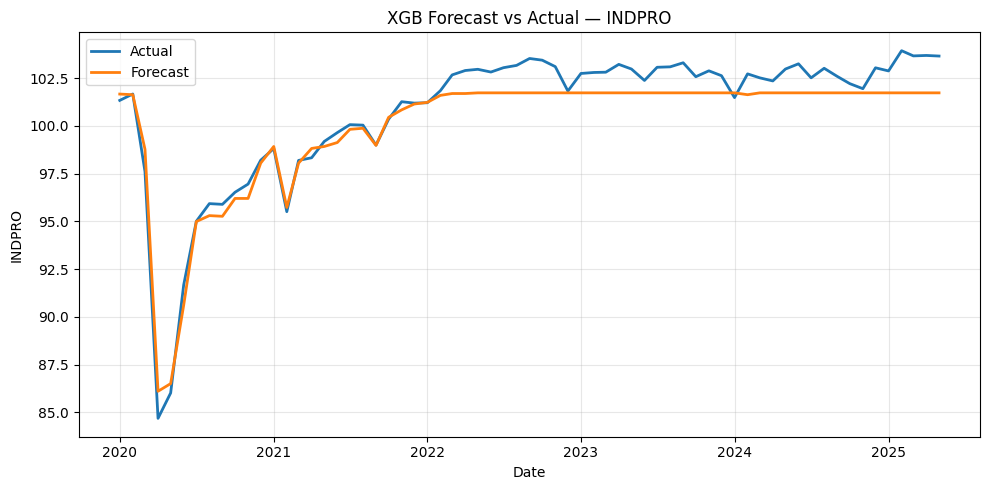

[I 2025-09-06 23:59:02,523] A new study created in memory with name: no-name-e68f1e3e-053f-41d0-8b4f-1f904f5c1cc3


✅ Model for INDPRO saved to models/xgb_model_INDPRO.pkl

XGBoost + Optuna Forecasting: 10_year_rate
🔍 DEBUG: Initial train shape: (635, 50), test shape: (65, 50)
🔍 DEBUG: Target 10_year_rate - train nulls: 0, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 54)
🔍 DEBUG: Lag column nulls: {'10_year_rate_lag1': 1, '10_year_rate_lag3': 3, '10_year_rate_lag6': 6, '10_year_rate_lag12': 12}
🔍 DEBUG: Using 37 features: ['seasonally_adjusted_unemployment_rate', 'CPI_trend', 'CPI_sumsq_acf_diff1', 'seasonally_adjusted_CPI', 'INDPRO_trend']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_unemployment_rate: 0 NaNs
   CPI_trend: 0 NaNs
   CPI_sumsq_acf_diff1: 11 NaNs
   seasonally_adjusted_CPI: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   INDPRO_acf1_original: 10 NaNs
   CPI_sumsq_acf_original: 10 NaNs
   INDPRO_sumsq_acf_original: 10 NaNs
   CPI_acf1_original: 10 NaNs
🔍 DEBUG: After cleaning - NaN counts in features:
   seasonally_adju

[I 2025-09-06 23:59:04,400] Trial 0 finished with value: 1.1435518898189831 and parameters: {'n_estimators': 1425, 'learning_rate': 0.011739049260145995, 'max_depth': 8, 'min_child_weight': 7.257636205601527, 'subsample': 0.7249893272487405, 'colsample_bytree': 0.7068640457653799, 'gamma': 0.7409872032048515, 'reg_alpha': 1.1880986201836858, 'reg_lambda': 0.8429990687205683}. Best is trial 0 with value: 1.1435518898189831.
[I 2025-09-06 23:59:04,674] Trial 1 finished with value: 1.533526238350435 and parameters: {'n_estimators': 952, 'learning_rate': 0.20524949034058151, 'max_depth': 2, 'min_child_weight': 7.948591842464782, 'subsample': 0.6610241440029794, 'colsample_bytree': 0.9554927395827728, 'gamma': 1.9399866501530445, 'reg_alpha': 3.856753532676932, 'reg_lambda': 2.3605699108064666}. Best is trial 0 with value: 1.1435518898189831.
[I 2025-09-06 23:59:05,054] Trial 2 finished with value: 1.6470083253282533 and parameters: {'n_estimators': 776, 'learning_rate': 0.108653564791023, 

🔧 Best params for 10_year_rate: {'n_estimators': 1249, 'learning_rate': 0.04839898343856546, 'max_depth': 5, 'min_child_weight': 9.78797201065848, 'subsample': 0.8166844207970014, 'colsample_bytree': 0.6054263750696007, 'gamma': 0.10122324898791603, 'reg_alpha': 0.041835568948152435, 'reg_lambda': 1.4726606788464824}
   Best val RMSE: 0.9191


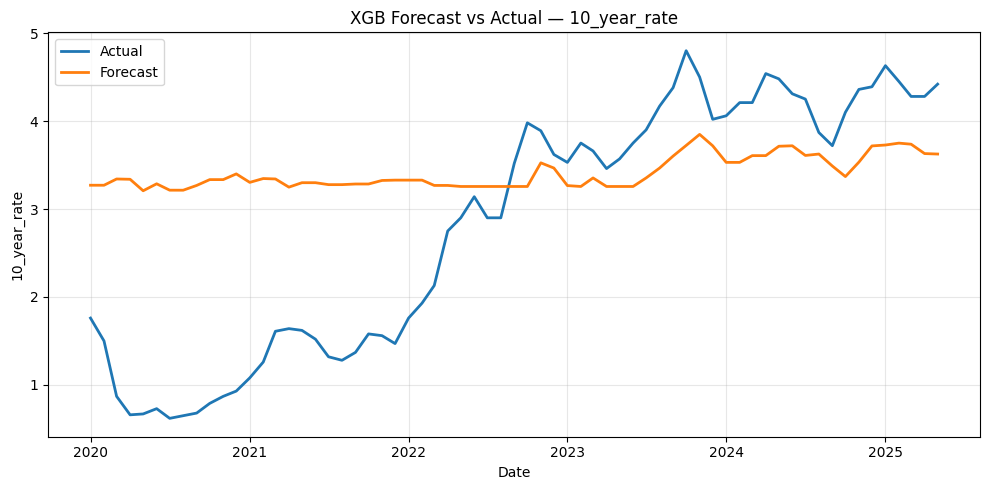

[I 2025-09-06 23:59:32,955] A new study created in memory with name: no-name-586fcabd-d92f-4af7-8ba0-06c564fb30a1


✅ Model for 10_year_rate saved to models/xgb_model_10_year_rate.pkl

XGBoost + Optuna Forecasting: share_price
🔍 DEBUG: Initial train shape: (635, 50), test shape: (65, 50)
🔍 DEBUG: Target share_price - train nulls: 0, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 54)
🔍 DEBUG: Lag column nulls: {'share_price_lag1': 1, 'share_price_lag3': 3, 'share_price_lag6': 6, 'share_price_lag12': 12}
🔍 DEBUG: Using 37 features: ['seasonally_adjusted_unemployment_rate', 'CPI_trend', 'CPI_sumsq_acf_diff1', 'seasonally_adjusted_CPI', 'INDPRO_trend']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_unemployment_rate: 0 NaNs
   CPI_trend: 0 NaNs
   CPI_sumsq_acf_diff1: 11 NaNs
   seasonally_adjusted_CPI: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   INDPRO_acf1_original: 10 NaNs
   CPI_sumsq_acf_original: 10 NaNs
   INDPRO_sumsq_acf_original: 10 NaNs
   CPI_acf1_original: 10 NaNs
🔍 DEBUG: After cleaning - NaN counts in features:
   seasonall

[I 2025-09-06 23:59:33,368] Trial 0 finished with value: 0.6034883564881698 and parameters: {'n_estimators': 1653, 'learning_rate': 0.035912884181782664, 'max_depth': 6, 'min_child_weight': 8.815874835509774, 'subsample': 0.7522334348483243, 'colsample_bytree': 0.8065982607934641, 'gamma': 1.1549385693531578, 'reg_alpha': 4.148608888317282, 'reg_lambda': 1.7388803996861324}. Best is trial 0 with value: 0.6034883564881698.
[I 2025-09-06 23:59:33,584] Trial 1 finished with value: 0.5955986548352865 and parameters: {'n_estimators': 1156, 'learning_rate': 0.04061252902852061, 'max_depth': 3, 'min_child_weight': 3.783776481645065, 'subsample': 0.9940904303499123, 'colsample_bytree': 0.6218702433169266, 'gamma': 2.537332717690377, 'reg_alpha': 1.671808582021438, 'reg_lambda': 2.4432931760734036}. Best is trial 1 with value: 0.5955986548352865.
[I 2025-09-06 23:59:34,062] Trial 2 finished with value: 0.6016626950694904 and parameters: {'n_estimators': 1537, 'learning_rate': 0.0316372925576494

🔧 Best params for share_price: {'n_estimators': 564, 'learning_rate': 0.07921846431968693, 'max_depth': 8, 'min_child_weight': 2.8053500542209915, 'subsample': 0.8558796139869703, 'colsample_bytree': 0.9094718223982003, 'gamma': 0.0744876038494107, 'reg_alpha': 0.06266392995914793, 'reg_lambda': 0.5227280326552888}
   Best val RMSE: 0.3169


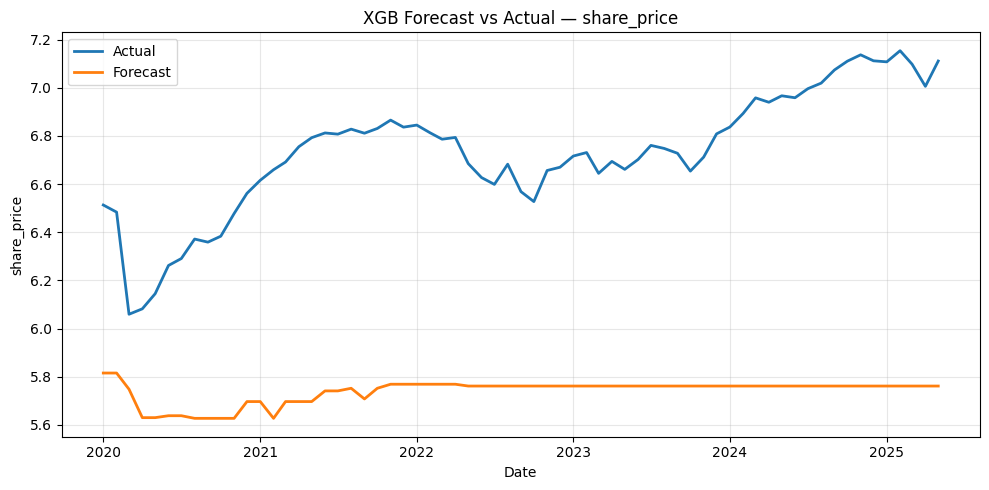

[I 2025-09-06 23:59:49,488] A new study created in memory with name: no-name-db3b1fb2-995a-4f44-989c-4d23c6458ae2


✅ Model for share_price saved to models/xgb_model_share_price.pkl

XGBoost + Optuna Forecasting: unemployment_rate
🔍 DEBUG: Initial train shape: (635, 50), test shape: (65, 50)
🔍 DEBUG: Target unemployment_rate - train nulls: 0, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 54)
🔍 DEBUG: Lag column nulls: {'unemployment_rate_lag1': 1, 'unemployment_rate_lag3': 3, 'unemployment_rate_lag6': 6, 'unemployment_rate_lag12': 12}
🔍 DEBUG: Using 37 features: ['seasonally_adjusted_unemployment_rate', 'CPI_trend', 'CPI_sumsq_acf_diff1', 'seasonally_adjusted_CPI', 'INDPRO_trend']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_unemployment_rate: 0 NaNs
   CPI_trend: 0 NaNs
   CPI_sumsq_acf_diff1: 11 NaNs
   seasonally_adjusted_CPI: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   INDPRO_acf1_original: 10 NaNs
   CPI_sumsq_acf_original: 10 NaNs
   INDPRO_sumsq_acf_original: 10 NaNs
   CPI_acf1_original: 10 NaNs
🔍 DEBUG: After cleaning - Na

[I 2025-09-06 23:59:49,804] Trial 0 finished with value: 0.17354536688845906 and parameters: {'n_estimators': 697, 'learning_rate': 0.05473486353267764, 'max_depth': 7, 'min_child_weight': 8.450077020177403, 'subsample': 0.8150146289791681, 'colsample_bytree': 0.7390635303074617, 'gamma': 3.0157693280321634, 'reg_alpha': 2.2323760536239154, 'reg_lambda': 2.0720194531077754}. Best is trial 0 with value: 0.17354536688845906.
[I 2025-09-06 23:59:50,242] Trial 1 finished with value: 0.09331738374153138 and parameters: {'n_estimators': 1777, 'learning_rate': 0.06080847061754267, 'max_depth': 8, 'min_child_weight': 5.368608013081052, 'subsample': 0.6021167266372457, 'colsample_bytree': 0.8914149891857213, 'gamma': 0.5429674433747511, 'reg_alpha': 0.9923086349372096, 'reg_lambda': 3.2041008463218974}. Best is trial 1 with value: 0.09331738374153138.
[I 2025-09-06 23:59:51,054] Trial 2 finished with value: 0.2001111743862989 and parameters: {'n_estimators': 1366, 'learning_rate': 0.01807920182

🔧 Best params for unemployment_rate: {'n_estimators': 569, 'learning_rate': 0.033208013847609366, 'max_depth': 6, 'min_child_weight': 7.162429682799163, 'subsample': 0.6438417172372315, 'colsample_bytree': 0.7878987762602573, 'gamma': 0.04031137366378925, 'reg_alpha': 2.6207445792666224, 'reg_lambda': 1.4607835377433331}
   Best val RMSE: 0.0825


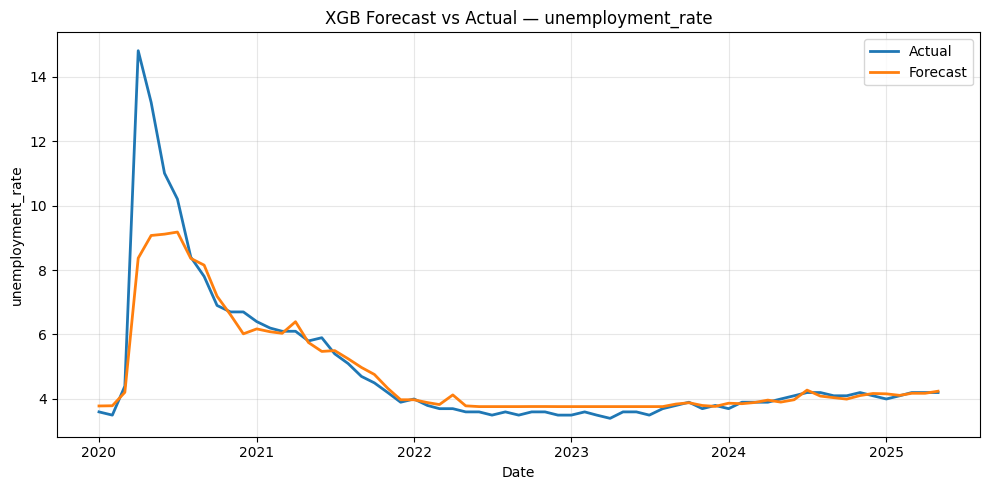

[I 2025-09-07 00:00:13,015] A new study created in memory with name: no-name-473b338b-278a-47c2-ba6e-4fff9e72f814


✅ Model for unemployment_rate saved to models/xgb_model_unemployment_rate.pkl

XGBoost + Optuna Forecasting: PPI
🔍 DEBUG: Initial train shape: (635, 50), test shape: (65, 50)
🔍 DEBUG: Target PPI - train nulls: 0, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 54)
🔍 DEBUG: Lag column nulls: {'PPI_lag1': 1, 'PPI_lag3': 3, 'PPI_lag6': 6, 'PPI_lag12': 12}
🔍 DEBUG: Using 37 features: ['seasonally_adjusted_unemployment_rate', 'CPI_trend', 'CPI_sumsq_acf_diff1', 'seasonally_adjusted_CPI', 'INDPRO_trend']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_unemployment_rate: 0 NaNs
   CPI_trend: 0 NaNs
   CPI_sumsq_acf_diff1: 11 NaNs
   seasonally_adjusted_CPI: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   INDPRO_acf1_original: 10 NaNs
   CPI_sumsq_acf_original: 10 NaNs
   INDPRO_sumsq_acf_original: 10 NaNs
   CPI_acf1_original: 10 NaNs
🔍 DEBUG: After cleaning - NaN counts in features:
   seasonally_adjusted_unemployment_rate: 0 NaNs
 

[I 2025-09-07 00:00:13,240] Trial 0 finished with value: 19.637350906850436 and parameters: {'n_estimators': 1077, 'learning_rate': 0.26802838758456304, 'max_depth': 3, 'min_child_weight': 8.842763956287694, 'subsample': 0.8199213041047496, 'colsample_bytree': 0.954737894751618, 'gamma': 0.38721261390796624, 'reg_alpha': 4.749042215174712, 'reg_lambda': 0.9086567024047925}. Best is trial 0 with value: 19.637350906850436.
[I 2025-09-07 00:00:15,085] Trial 1 finished with value: 18.217220355567424 and parameters: {'n_estimators': 680, 'learning_rate': 0.01501979469361068, 'max_depth': 6, 'min_child_weight': 4.823430258489383, 'subsample': 0.6254329599749935, 'colsample_bytree': 0.7083938681278558, 'gamma': 4.940002695351931, 'reg_alpha': 0.8825787250736278, 'reg_lambda': 2.80922826146885}. Best is trial 1 with value: 18.217220355567424.
[I 2025-09-07 00:00:16,501] Trial 2 finished with value: 19.173742161430607 and parameters: {'n_estimators': 1458, 'learning_rate': 0.018929062426548283,

🔧 Best params for PPI: {'n_estimators': 1554, 'learning_rate': 0.20926138523865417, 'max_depth': 4, 'min_child_weight': 1.8684808492596359, 'subsample': 0.7169410700064033, 'colsample_bytree': 0.6286006296954434, 'gamma': 3.217123228265332, 'reg_alpha': 0.37593453346099537, 'reg_lambda': 4.1027185000292}
   Best val RMSE: 13.5402


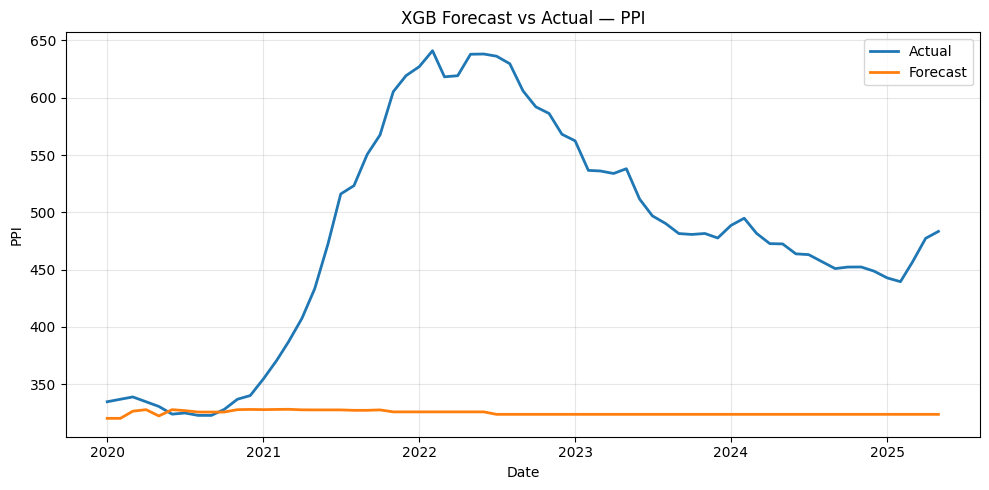

[I 2025-09-07 00:00:36,943] A new study created in memory with name: no-name-f4fcf756-53ed-4440-a52e-7036ba885d79


✅ Model for PPI saved to models/xgb_model_PPI.pkl

XGBoost + Optuna Forecasting: OECD_CLI_index
🔍 DEBUG: Initial train shape: (635, 50), test shape: (65, 50)
🔍 DEBUG: Target OECD_CLI_index - train nulls: 0, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 54)
🔍 DEBUG: Lag column nulls: {'OECD_CLI_index_lag1': 1, 'OECD_CLI_index_lag3': 3, 'OECD_CLI_index_lag6': 6, 'OECD_CLI_index_lag12': 12}
🔍 DEBUG: Using 37 features: ['seasonally_adjusted_unemployment_rate', 'CPI_trend', 'CPI_sumsq_acf_diff1', 'seasonally_adjusted_CPI', 'INDPRO_trend']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_unemployment_rate: 0 NaNs
   CPI_trend: 0 NaNs
   CPI_sumsq_acf_diff1: 11 NaNs
   seasonally_adjusted_CPI: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   INDPRO_acf1_original: 10 NaNs
   CPI_sumsq_acf_original: 10 NaNs
   INDPRO_sumsq_acf_original: 10 NaNs
   CPI_acf1_original: 10 NaNs
🔍 DEBUG: After cleaning - NaN counts in features:
   seasonall

[I 2025-09-07 00:00:37,242] Trial 0 finished with value: 0.3341066782773244 and parameters: {'n_estimators': 1056, 'learning_rate': 0.020511047899542462, 'max_depth': 2, 'min_child_weight': 3.388944301447776, 'subsample': 0.8022269828834541, 'colsample_bytree': 0.7551733259193738, 'gamma': 2.1269962672622995, 'reg_alpha': 2.9155843934252346, 'reg_lambda': 2.0521786596800853}. Best is trial 0 with value: 0.3341066782773244.
[I 2025-09-07 00:00:37,376] Trial 1 finished with value: 0.32356628571778806 and parameters: {'n_estimators': 1307, 'learning_rate': 0.20855506893546963, 'max_depth': 6, 'min_child_weight': 6.908391934843083, 'subsample': 0.6225239967459874, 'colsample_bytree': 0.8889982239366013, 'gamma': 0.737388582573385, 'reg_alpha': 2.539842850484844, 'reg_lambda': 3.0554286312280956}. Best is trial 1 with value: 0.32356628571778806.
[I 2025-09-07 00:00:37,595] Trial 2 finished with value: 0.24101353006974877 and parameters: {'n_estimators': 1485, 'learning_rate': 0.059093240514

🔧 Best params for OECD_CLI_index: {'n_estimators': 1787, 'learning_rate': 0.014259151739621674, 'max_depth': 6, 'min_child_weight': 1.493323927545335, 'subsample': 0.9277286068840218, 'colsample_bytree': 0.9743421282697144, 'gamma': 0.3434576257646995, 'reg_alpha': 0.18242944344470857, 'reg_lambda': 3.0715994517181096}
   Best val RMSE: 0.1458


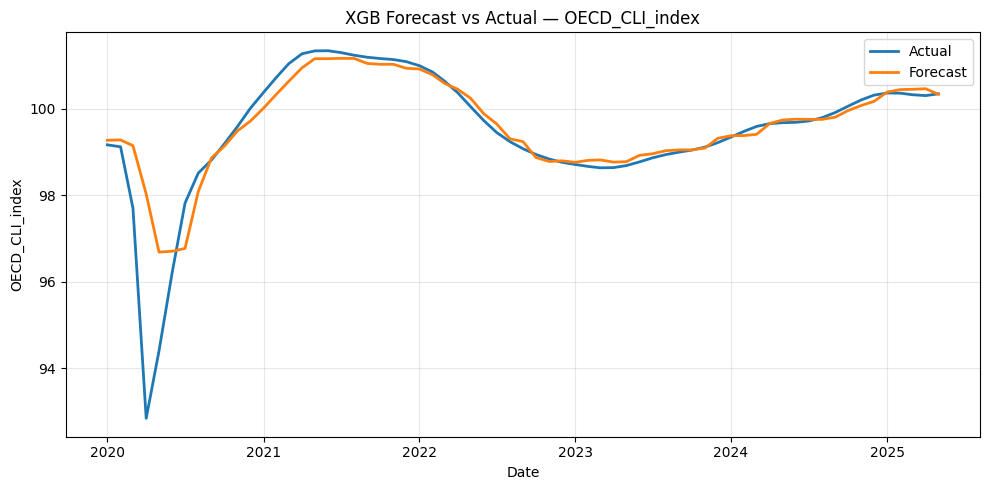

[I 2025-09-07 00:00:53,856] A new study created in memory with name: no-name-f8e886df-eeaf-40d0-ac17-cf9749479f34


✅ Model for OECD_CLI_index saved to models/xgb_model_OECD_CLI_index.pkl

XGBoost + Optuna Forecasting: CSI_index
🔍 DEBUG: Initial train shape: (635, 50), test shape: (65, 50)
🔍 DEBUG: Target CSI_index - train nulls: 0, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 54)
🔍 DEBUG: Lag column nulls: {'CSI_index_lag1': 1, 'CSI_index_lag3': 3, 'CSI_index_lag6': 6, 'CSI_index_lag12': 12}
🔍 DEBUG: Using 37 features: ['seasonally_adjusted_unemployment_rate', 'CPI_trend', 'CPI_sumsq_acf_diff1', 'seasonally_adjusted_CPI', 'INDPRO_trend']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_unemployment_rate: 0 NaNs
   CPI_trend: 0 NaNs
   CPI_sumsq_acf_diff1: 11 NaNs
   seasonally_adjusted_CPI: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   INDPRO_acf1_original: 10 NaNs
   CPI_sumsq_acf_original: 10 NaNs
   INDPRO_sumsq_acf_original: 10 NaNs
   CPI_acf1_original: 10 NaNs
🔍 DEBUG: After cleaning - NaN counts in features:
   seasonally_adjust

[I 2025-09-07 00:00:54,302] Trial 0 finished with value: 3.8594345030226727 and parameters: {'n_estimators': 1097, 'learning_rate': 0.034212742810099436, 'max_depth': 8, 'min_child_weight': 9.02199639128218, 'subsample': 0.6942884497212116, 'colsample_bytree': 0.970015585618256, 'gamma': 3.244367105328479, 'reg_alpha': 3.827414530498277, 'reg_lambda': 4.659930553716137}. Best is trial 0 with value: 3.8594345030226727.
[I 2025-09-07 00:00:55,085] Trial 1 finished with value: 5.170079895622366 and parameters: {'n_estimators': 873, 'learning_rate': 0.021875252871213967, 'max_depth': 6, 'min_child_weight': 1.345769204596308, 'subsample': 0.8430240002226178, 'colsample_bytree': 0.9556738981721963, 'gamma': 2.3121302465050038, 'reg_alpha': 1.481325810203324, 'reg_lambda': 0.8284989141443919}. Best is trial 0 with value: 3.8594345030226727.
[I 2025-09-07 00:00:55,277] Trial 2 finished with value: 3.777795491760502 and parameters: {'n_estimators': 287, 'learning_rate': 0.056192354290525943, 'm

🔧 Best params for CSI_index: {'n_estimators': 514, 'learning_rate': 0.04929628896172169, 'max_depth': 2, 'min_child_weight': 9.973699175528175, 'subsample': 0.8257504246723519, 'colsample_bytree': 0.8632633178679253, 'gamma': 3.957572092088799, 'reg_alpha': 4.930834166178892, 'reg_lambda': 4.086418588767691}
   Best val RMSE: 3.6902


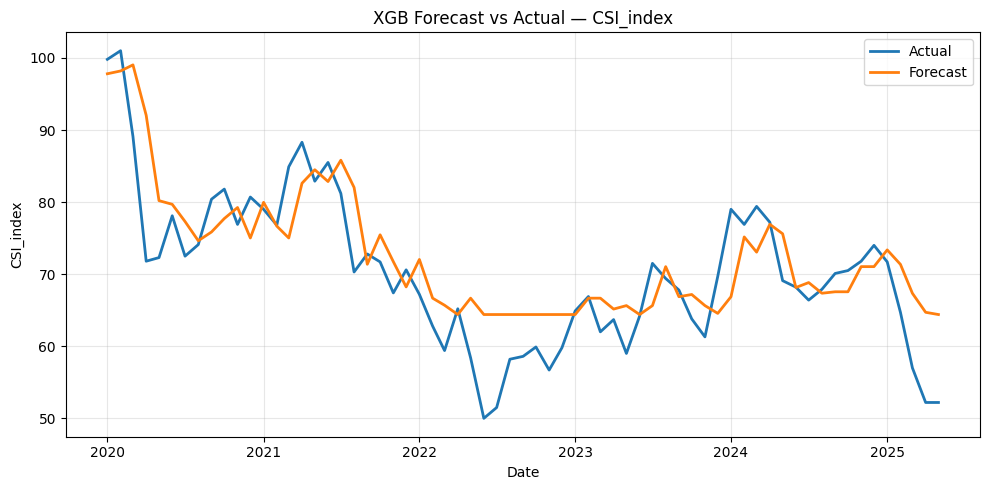

[I 2025-09-07 00:01:04,985] A new study created in memory with name: no-name-38db8d13-0e08-44fb-a72f-fdb71f468904


✅ Model for CSI_index saved to models/xgb_model_CSI_index.pkl

XGBoost + Optuna Forecasting: gdp_per_capita
🔍 DEBUG: Initial train shape: (635, 50), test shape: (65, 50)
🔍 DEBUG: Target gdp_per_capita - train nulls: 0, test nulls: 1
🔍 DEBUG: After adding lags, shape: (700, 54)
🔍 DEBUG: Lag column nulls: {'gdp_per_capita_lag1': 1, 'gdp_per_capita_lag3': 3, 'gdp_per_capita_lag6': 6, 'gdp_per_capita_lag12': 12}
🔍 DEBUG: Using 37 features: ['seasonally_adjusted_unemployment_rate', 'CPI_trend', 'CPI_sumsq_acf_diff1', 'seasonally_adjusted_CPI', 'INDPRO_trend']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_unemployment_rate: 0 NaNs
   CPI_trend: 0 NaNs
   CPI_sumsq_acf_diff1: 11 NaNs
   seasonally_adjusted_CPI: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   INDPRO_acf1_original: 10 NaNs
   CPI_sumsq_acf_original: 10 NaNs
   INDPRO_sumsq_acf_original: 10 NaNs
   CPI_acf1_original: 10 NaNs
🔍 DEBUG: After cleaning - NaN counts in features:


[I 2025-09-07 00:01:06,458] Trial 0 finished with value: 3664.2561702191006 and parameters: {'n_estimators': 795, 'learning_rate': 0.024252803436830266, 'max_depth': 7, 'min_child_weight': 7.827142688394264, 'subsample': 0.6658236462048476, 'colsample_bytree': 0.8101522122564337, 'gamma': 4.755060130477348, 'reg_alpha': 2.3235059654759445, 'reg_lambda': 1.7878005507033843}. Best is trial 0 with value: 3664.2561702191006.
[I 2025-09-07 00:01:06,705] Trial 1 finished with value: 3585.4525396172 and parameters: {'n_estimators': 1805, 'learning_rate': 0.26150548853741856, 'max_depth': 5, 'min_child_weight': 4.02938186140829, 'subsample': 0.9973303897761002, 'colsample_bytree': 0.7507440748511158, 'gamma': 0.864111405027157, 'reg_alpha': 3.5025428000783143, 'reg_lambda': 3.665987160269612}. Best is trial 1 with value: 3585.4525396172.
[I 2025-09-07 00:01:07,693] Trial 2 finished with value: 3649.4439419932596 and parameters: {'n_estimators': 552, 'learning_rate': 0.012646522173323129, 'max_

🔧 Best params for gdp_per_capita: {'n_estimators': 1733, 'learning_rate': 0.04672772946358595, 'max_depth': 8, 'min_child_weight': 3.111876249139102, 'subsample': 0.937876729078704, 'colsample_bytree': 0.9986667445999411, 'gamma': 3.485179842189221, 'reg_alpha': 1.534729829447933, 'reg_lambda': 1.5139526355818247}
   Best val RMSE: 3455.4844


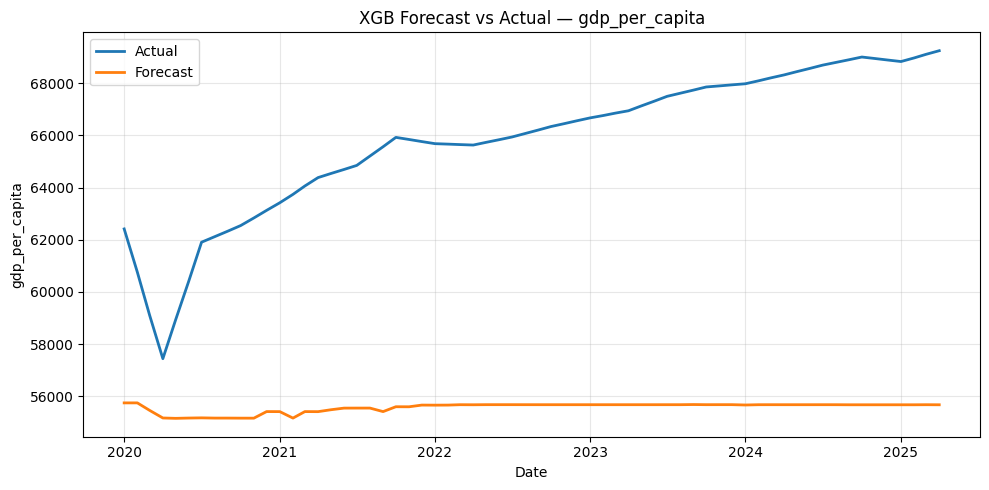

✅ Model for gdp_per_capita saved to models/xgb_model_gdp_per_capita.pkl

📊 Forecast Performance Metrics (TEST: 2020+)
                          MAE        RMSE    MAPE_%
Indicator                                          
10_year_rate           1.1622      1.4191   92.2418
1_year_rate            0.9458      1.0192  297.3944
3_months_rate          0.4402      0.5175  256.8734
6_months_rate          0.6380      0.7152  268.9910
CPI                   72.7376     75.9312   24.5956
CSI_index              4.8210      6.3281    7.3324
INDPRO                 0.8558      1.0341    0.8435
OECD_CLI_index         0.2763      0.7544    0.2857
PPI                  155.5610    183.5083   29.3125
gdp_per_capita     10227.4348  10555.8888   15.3989
share_price            0.9940      1.0196   14.6585
unemployment_rate      0.3576      1.0042    5.0891


,MAE,RMSE,MAPE_%
Indicator,,,
10_year_rate,1.1622,1.4191,92.2418
1_year_rate,0.9458,1.0192,297.3944
3_months_rate,0.4402,0.5175,256.8734
6_months_rate,0.6380,0.7152,268.9910
CPI,72.7376,75.9312,24.5956
CSI_index,4.8210,6.3281,7.3324
INDPRO,0.8558,1.0341,0.8435
OECD_CLI_index,0.2763,0.7544,0.2857
PPI,155.5610,183.5083,29.3125


In [15]:
# -----------------------------
# USAGE EXAMPLE
# -----------------------------
results = run_xgb_optuna_pipeline(
    dim_reduced_df,
    financial_indicators=financial_indicators,
    recession_targets=recession_targets,
    lags=(1,3,6,12),
    n_trials=40,           # increase for more thorough tuning
    include_exog=True,
    plot_results=True,
    seed=42
)
metrics_table = results["metrics"]
metrics_table